### Data loading

In [1]:
import trimap
import pandas as pd

In [2]:
chronos = pd.read_csv("../data/CRISPR_gene_effect.csv",index_col=0)
chronos.columns = [c.split()[0].upper() + '_Chronos' for c in chronos.columns]
expression = pd.read_csv("../data/CCLE_expression.csv", index_col=0)
expression.columns = [c.split()[0].upper()+'_Expression' for c in expression.columns]
sample_info = pd.read_csv("../data/sample_info.csv", index_col=0)
ch_ex = chronos.merge(expression, right_index=True, left_index=True).dropna()

In [3]:
id_to_name = {i:n for i, n in zip(sample_info.index, sample_info["stripped_cell_line_name"])}
name_to_id = {n:i for i, n in zip(sample_info.index, sample_info["stripped_cell_line_name"])}
name_to_lineage = {n:l for n, l in zip(sample_info["stripped_cell_line_name"], sample_info["lineage"])}
ch_ex.index = [id_to_name.get(n,n) for n in ch_ex.index]

### Scatter plots (Fig. S3a-b)

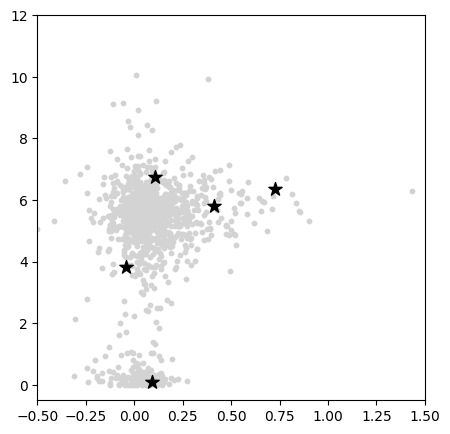

In [4]:
#Fig. S5a, b
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))
x = 'KIRREL1_Chronos'
y = 'YAP1_Expression'
cells = ['RPE1SS48','U2OS','MCF7','K562','PANC1']

plt.scatter(ch_ex[x],ch_ex[y],s=10,c='lightgray')
plt.scatter(ch_ex.loc[cells,x],ch_ex.loc[cells,y],s=100,c='black',marker='*')
plt.xlim((-0.5,1.5))
plt.ylim((-0.5,12))


plt.savefig('../result/figure.svg',dpi=300)

### Dimensionality reduction Optimization (Fig.S3d-f)

In [5]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import networkx as nx
from sklearn.neighbors import kneighbors_graph

hippo_chr=['AMOTL2', 'KIRREL1', 'NF2', 'PDCD10', 'RNF146', 'TAOK1', 'PTPN14', 'MAP4K4', 'FRYL',  'LATS2',  'NRP1']
hippo_exp=['YAP1','WWTR1','CCN1','CCN2']
features = [gene + '_Chronos' for gene in hippo_chr] + [gene + '_Expression' for gene in hippo_exp] 
scaled_data = StandardScaler().fit_transform(ch_ex[features]) 

In [ ]:
#Modularity score
#Fig.S3e
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.metrics.pairwise import rbf_kernel
import igraph as ig
import leidenalg as la

dimensionality_reduction_methods = {
    "UMAP": umap.UMAP(random_state=0, n_neighbors=6, min_dist=0.08),
    "PCA": PCA(n_components=2),
    "t-SNE": TSNE(n_components=2, random_state=0),
    "Trimap": trimap.TRIMAP(n_dims=2, n_outliers=10, n_inliers=10)
}

embeddings = {}
graphs = {}
results = []
for method_name, reducer in dimensionality_reduction_methods.items():
    print(method_name)
    embedding = reducer.fit_transform(scaled_data)
    embedding = embedding - np.mean(embedding,axis=0)
    scaled_embedding = embedding / np.max(np.abs(embedding))
    embeddings[method_name] = scaled_embedding
    W_rbf = rbf_kernel(scaled_embedding, gamma= 30)
    W_rbf_symmetric = (W_rbf + W_rbf.T) / 2
    G_igraph = ig.Graph.Weighted_Adjacency(W_rbf_symmetric, mode='undirected')
    graphs[method_name] = G_igraph
    for r in range(1,21):
        r = r *0.1
        partition = la.find_partition(
            G_igraph,
            la.RBConfigurationVertexPartition,
            weights='weight',
            resolution_parameter=r,
            seed=0)

        leiden_labels = np.array(partition.membership)
        modularity = G_igraph.modularity(partition.membership, weights='weight')
        results.append([method_name, "Leiden Clustering", r, modularity])

df_results = pd.DataFrame(results, columns=["Dimensionality Reduction", "Clustering Method", "k", "Modularity Score"])

UMAP


c:\Users\ki949\AppData\Local\Programs\Python\Python39\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


PCA
t-SNE
Trimap


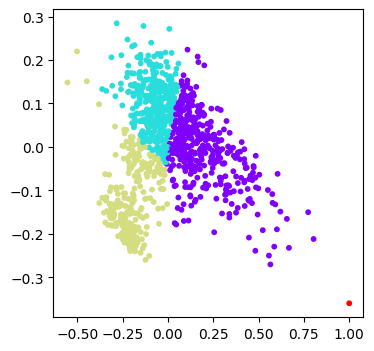

In [ ]:
#Fig. S3d
import matplotlib.pyplot as plt
r = 0.8
method = 'PCA'
emb = embeddings[method]
G_igraph = graphs[method]

partition = la.find_partition(
        G_igraph,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=r,
        seed=0)

leiden_labels = np.array(partition.membership)
plt.figure(figsize=(4, 4))

plt.scatter(emb[:, 0], emb[:, 1], c=leiden_labels, s=10, cmap='rainbow')
plt.savefig('../result/figure.svg',dpi=300)
plt.show()

In [ ]:
#Global Score (GS)
#Fig. S3f
import numpy as np
X = scaled_data.T
y_pca = embeddings['PCA'].T
print(X.shape, y_pca.shape)
a = X@(y_pca.T)@np.linalg.inv(y_pca@y_pca.T)
e_pca = np.linalg.norm(X-a@y_pca,'fro')**2

def calc_e(X, y):
    a = X@(y.T)@np.linalg.inv(y@y.T)
    return np.linalg.norm(X-a@y,'fro')**2

e_pca = calc_e(X, y_pca)
y_umap = embeddings['UMAP'].T
e_umap = calc_e(X, y_umap)

y_tsne = embeddings['t-SNE'].T
e_tsne = calc_e(X, y_tsne)

y_trimap = embeddings['Trimap'].T
e_trimap = calc_e(X, y_trimap)

GS_pca = np.exp(-(e_pca-e_pca)/(e_pca))
GS_umap = np.exp(-(e_umap-e_pca)/(e_pca))
GS_tsne = np.exp(-(e_tsne-e_pca)/(e_pca))
GS_trimap = np.exp(-(e_trimap-e_pca)/(e_pca))

print("GS PCA:", GS_pca)
print("GS UMAP:", GS_umap)
print("GS t-SNE:", GS_tsne)
print("GS Trimap:", GS_trimap)

(15, 1001) (2, 1001)
GS PCA: 1.0
GS UMAP: 0.7605970727542579
GS t-SNE: 0.6958446679451283
GS Trimap: 0.8620874351991314


### TriMAP visualization (Figs. 2c, S4b, c, e)

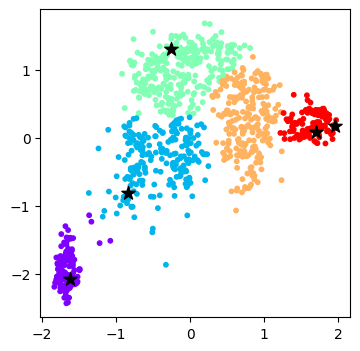

In [8]:
#Fig. 2C
import numpy as np
import pandas as pd
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
from sklearn.metrics.pairwise import rbf_kernel
import igraph as ig
import leidenalg as la

embedding = pd.read_csv("../trimap_hippo.csv",index_col=0).values
emb = StandardScaler().fit_transform(embedding)
W_rbf = rbf_kernel(emb, gamma=5)
W_rbf_symmetric = (W_rbf + W_rbf.T) / 2
G_igraph = ig.Graph.Weighted_Adjacency(W_rbf_symmetric, mode='undirected')

r = 0.6
partition = la.find_partition(
        G_igraph,
        la.RBConfigurationVertexPartition,
        weights='weight',
        resolution_parameter=r,
        seed=0)

leiden_labels = np.array(partition.membership)
mapping = {4: 4, 2: 1, 1: 3, 0: 2, 3: 0}

updated_labels = [mapping[x] for x in leiden_labels]
plt.figure(figsize=(4, 4))
plt.scatter(emb[:, 0], emb[:, 1], c=updated_labels, s=10, cmap='rainbow')

cells = ['RPE1SS6','U2OS','MCF7','K562','PANC1']
cells_index = []
for cell in cells:
    cells_index.append(ch_ex.index.get_loc(cell))
plt.scatter(emb[cells_index, 0], emb[cells_index, 1], s=100, c='black', marker='*')

plt.savefig('../result/figure.svg', dpi=300)
plt.show()

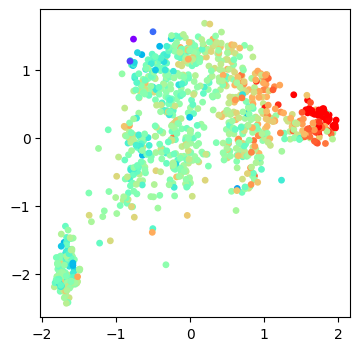

In [ ]:
#Fig. S4c
plt.figure(figsize=(4,4))
plt.scatter(
    emb[:, 0],
    emb[:, 1], c=ch_ex['KIRREL1_Chronos'], cmap='rainbow', vmax=0.5, vmin=-0.5, s=15)


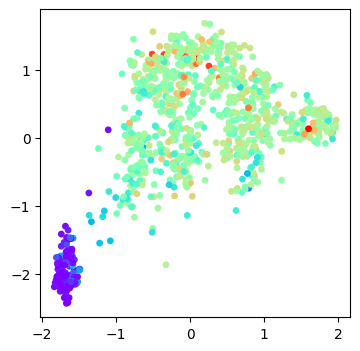

In [ ]:
#Fig. S4b
plt.figure(figsize=(4,4))
plt.scatter(
    scaled_embedding[:, 0],
    scaled_embedding[:, 1], c=ch_ex['YAP1_Expression'], cmap='rainbow', vmax=10, vmin= 0, s=15)